# Week 1: Making Data-Driven Decisions in RAG Applications

Building effective RAG (Retrieval-Augmented Generation) applications isn't just about implementing the latest techniques—it's about making informed decisions based on empirical evidence. This notebook introduces a systematic approach to evaluating and improving your RAG pipeline through rigorous experimentation and analysis.

## What You'll Learn

Through hands-on experiments with a Text-to-SQL retrieval system, you'll discover:

- How to quantitatively compare different retrieval strategies using industry-standard metrics
- When to use embedding search vs. hybrid search, and the surprising performance implications
- Whether investing in re-rankers or larger embedding models gives you better returns
- A framework for making data-driven decisions about your RAG architecture

## Key Insights

Our experiments revealed some counterintuitive findings that highlight why empirical testing is crucial:

1. Embedding search outperformed hybrid search in both recall and MRR metrics, suggesting that improving hybrid search might require better query preprocessing
2. Upgrading from `text-embedding-3-small` to `text-embedding-3-large` provided better performance gains than adding a re-ranker
3. For our specific use case, the simpler architecture (pure embedding search) actually performed better than more complex alternatives

## Prerequisites

Before starting this notebook, please run the `1. synthetic_questions.ipynb` notebook to generate the evaluation dataset we'll use for our experiments.

## Why This Matters

As RAG systems become more complex, intuition alone isn't enough to guide architectural decisions. This notebook provides you with:

- A reproducible methodology for evaluating retrieval components
- Tools for measuring the impact of different architectural choices
- A framework for making cost-benefit tradeoffs based on actual performance data

Let's dive in and see how to make your RAG pipeline decisions more rigorous and data-driven.

## Setting up Our Retrieval Pipeline

In this example, we're using a local `lancedb` instance. We're doing so because of 3 reasons.

1. LanceDB handles the embeddings of our data for us 
2. It provides embedding search, hybrid search and other re-ranking methods all within a single api.
3. We can use Pydantic to define our table schema and easily ingest our data.

This makes it quick and easy for us to compare the performance of each method.

In [5]:
import datasets
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from lancedb.table import Table


def get_or_create_lancedb_table(db: Table, table_name: str, embedding_model: str):
    if table_name in db.table_names():
        print(f"Table {table_name} already exists")
        return db.open_table(table_name)

    func = get_registry().get("openai").create(name=embedding_model)

    class Chunk(LanceModel):
        id: str
        query: str = func.SourceField()
        vector: Vector(func.ndims()) = func.VectorField()

    table = db.create_table(table_name, schema=Chunk, mode="overwrite")
    dataset = datasets.load_dataset("567-labs/bird-rag")["train"]
    formatted_dataset = [{"id": item["id"], "query": item["query"]} for item in dataset]

    table.create_fts_index("query", replace=True)
    print(f"{table.count_rows()} chunks ingested into the database")
    return table


# Create LanceDB Instance
db = lancedb.connect("./lancedb")
table_small = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_small", "text-embedding-3-small"
)
table_large = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_large", "text-embedding-3-large"
)

Table chunks_text_embedding_3_small already exists
Table chunks_text_embedding_3_large already exists


## Defining Metrics

Let's now start by evaluating the retrieval performance of our model. We'll do so by measuring the recall and MRR at different levels of k.

$$ \text{Recall} = \frac{\text{Number of Relevant Items Retrieved}}{\text{Total Number of Relevant Items}} $$ 

$$ \text{MRR} = \frac{\sum_{i=1}^{n} \frac{1}{rank(i)}}{n} $$ 

As models improve, their context window and reasoning abilities improve. This means that their ability to select relevant information in response to a user query will improve. By optimizing for recall, we ensure that the language model has access to all necessary information, which can lead to more accurate and reliable generated responses.

MRR@K is a useful metric if we want to display retrieved results as citations to users. We normally show a smaller list of retrieved results to users and we want to make sure that the correct result is ranked highly during retrieval so that it's more likely to be selected.

In [8]:
def calculate_mrr(predictions: list[str], gt: list[str]):
    mrr = 0
    for label in gt:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    # Calculate the proportion of relevant items that were retrieved
    return len([label for label in gt if label in predictions]) / len(gt)

## Parameterizing Your Retrieval

Now that we have a vector database with our data inside, we will now use it to evaluate different retrieval methods. Because LanceDB gives us the ability to use different retrieval methods in a single API, we can define a single `retrieve` function that can be easily modified to use different retrieval methods.

Once we've done so, we'll iterate over different subsets of the retrievewd items and compute the recall and mrr metrics. To log these scores to braintrust, we'll need to use the `Score` object.

In [9]:
from braintrust import Score
from lancedb.rerankers import CohereReranker
import lancedb
from lancedb.table import Table
from lancedb.rerankers import Reranker
from typing import Literal, Optional

db = lancedb.connect("./lancedb")
# Define Our Metrics
metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]
k = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]


def retrieve(
    question: str,
    table: Table,
    max_k=25,
    mode: Literal["vector", "fts", "hybrid"] = "vector",
    reranker: Optional[Reranker] = None,
    hooks=None,
):
    results = table.search(question, query_type=mode).limit(max_k)
    if reranker:
        results = results.rerank(reranker=reranker)
    return [
        {"id": result["id"], "query": result["query"]} for result in results.to_list()
    ]


# Similar to our previous section, we can use the id of each item to compute the recall and MRR metrics.
def evaluate_braintrust(input, output, **kwargs):
    # We first get the predictions ( what we retrieved ) and the labels
    predictions = [item["id"] for item in output]
    labels = [kwargs["metadata"]["chunk_id"]]

    scores = []
    for metric, score_fn in metrics:
        for subset_k in k:
            scores.append(
                Score(
                    name=f"{metric}@{subset_k}",
                    score=score_fn(predictions[:subset_k], labels),
                    metadata={"query": input, "result": output, **kwargs["metadata"]},
                )
            )

    return scores

We want to understand how each method performs when we vary the size of retrieve items with respect to recall and mrr. This helps us understand if a method is worth the cost and latency to implement. 

More practically, if a cheaper method has a recall@10 that's equivalent to a more expensive's method recall@5, then it might be worth it to start with the cheaper method first. Using these objective metrics, we can make an informed decision about which method to use. Let's see how we can do so with a simple example below.


In [19]:
from braintrust import init_dataset, Eval
from itertools import product
import uuid


# Load subset of evaluation queries
evaluation_queries = [
    item for item in init_dataset(project="Text-2-SQL", name="Bird-Bench-Questions")
]

# Evaluation configurations
available_rerankers = {
    "rerank-english-v3.0": CohereReranker(
        model_name="rerank-english-v3.0", column="query"
    ),
    "none": None,
}

search_query_modes = ["hybrid", "vector"]

embedding_model_to_table = {
    "text-embedding-3-small": table_small,
    "text-embedding-3-large": table_large,
}

# Run evaluations
evaluation_results = []
experiment_id = str(uuid.uuid4())
for reranker_name, search_mode, embedding_model in product(
    available_rerankers, search_query_modes, embedding_model_to_table
):
    # Get model instances
    current_reranker = available_rerankers[reranker_name]
    current_table = embedding_model_to_table[embedding_model]

    # Configure retrieval size
    retrieval_limit = 120 if current_reranker else 40

    # Run evaluation
    benchmark_result = await Eval(
        name="Text-2-SQL",
        experiment_name=f"{experiment_id}-{reranker_name}-{search_mode}-{embedding_model}",
        task=lambda query: retrieve(
            question=query,
            max_k=retrieval_limit,
            table=current_table,
            mode=search_mode,
            reranker=current_reranker,
        ),
        data=evaluation_queries,
        scores=[evaluate_braintrust],
        metadata={
            "embedding_model": embedding_model,
            "reranker": reranker_name,
            "query_mode": search_mode,
            "retrieval_limit": retrieval_limit,
        },
    )

    # Process benchmark results
    performance_scores = benchmark_result.summary.scores
    for metric_name, score_data in performance_scores.items():
        metric_type, top_k = metric_name.split("@")
        evaluation_results.append(
            {
                "metric": metric_type,
                "k": int(top_k),
                "reranker": reranker_name,
                "embedding_model": embedding_model,
                "query_type": search_mode,
                "score": score_data.score,
            }
        )

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-small
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-small] (data): 290it [00:00, 43161.99it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-s…


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-small compared to reranker-k-comparison-120-88e6c54e-23bb-4f32-840d-f4e817eb3b2e:
64.14% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
70.75% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
72.13% (-00.02%) 'mrr@5'     score	(0 improvements, 1 regressions)
73.36% (-00.02%) 'mrr@10'    score	(0 improvements, 1 regressions)
73.48% (-00.02%) 'mrr@15'    score	(0 improvements, 1 regressions)
73.54% (-00.02%) 'mrr@20'    score	(0 improvements, 3 regressions)
73.60% (-00.02%) 'mrr@25'    score	(0 improvements, 5 regressions)
73.60% (-00.02%) 'mrr@30'    score	(0 improvements, 5 regressions)
73.60% (-00.03%) 'mrr@35'    score	(0 improvements, 6 regressions)
73.62% (-00.02%) 'mrr@40'    score	(0 improvements, 6 regressions)
64.14% (-) 'recall@1'  score	(0 improvements, 0 regressions)
78.97% (-) 'recall@3'  score	(0 improvements, 0 regressions

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-large
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-large] (data): 290it [00:00, 64702.81it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-l…


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-large compared to 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-small:
64.14% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
70.75% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
72.13% (-) 'mrr@5'     score	(0 improvements, 0 regressions)
73.33% (-00.03%) 'mrr@10'    score	(1 improvements, 1 regressions)
73.48% (+00.00%) 'mrr@15'    score	(2 improvements, 1 regressions)
73.54% (+00.00%) 'mrr@20'    score	(2 improvements, 1 regressions)
73.60% (+00.00%) 'mrr@25'    score	(4 improvements, 3 regressions)
73.60% (+00.00%) 'mrr@30'    score	(4 improvements, 3 regressions)
73.60% (+00.00%) 'mrr@35'    score	(4 improvements, 3 regressions)
73.63% (+00.01%) 'mrr@40'    score	(5 improvements, 3 regressions)
64.14% (-) 'recall@1'  score	(0 improvements, 0 regressions)
78.97% (-) 'recall@3'  score	(0 improveme

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-small
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-small] (data): 290it [00:00, 35313.79it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-s…


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-small compared to 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-hybrid-text-embedding-3-large:
64.14% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
70.75% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
72.14% (+00.02%) 'mrr@5'     score	(1 improvements, 0 regressions)
73.38% (+00.05%) 'mrr@10'    score	(2 improvements, 1 regressions)
73.50% (+00.02%) 'mrr@15'    score	(2 improvements, 2 regressions)
73.56% (+00.02%) 'mrr@20'    score	(4 improvements, 2 regressions)
73.62% (+00.02%) 'mrr@25'    score	(6 improvements, 3 regressions)
73.62% (+00.02%) 'mrr@30'    score	(6 improvements, 3 regressions)
73.63% (+00.03%) 'mrr@35'    score	(7 improvements, 3 regressions)
73.64% (+00.01%) 'mrr@40'    score	(7 improvements, 4 regressions)
64.14% (-) 'recall@1'  score	(0 improvements, 0 regressions)
78.97% (-) 'recall@3'  score	(0 imp

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-large
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-large] (data): 290it [00:00, 37834.71it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-l…


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-large compared to 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-small:
64.14% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
70.75% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
72.14% (-) 'mrr@5'     score	(0 improvements, 0 regressions)
73.35% (-00.03%) 'mrr@10'    score	(1 improvements, 1 regressions)
73.52% (+00.02%) 'mrr@15'    score	(3 improvements, 1 regressions)
73.56% (+00.00%) 'mrr@20'    score	(3 improvements, 2 regressions)
73.62% (+00.00%) 'mrr@25'    score	(4 improvements, 4 regressions)
73.62% (+00.00%) 'mrr@30'    score	(4 improvements, 4 regressions)
73.63% (+00.00%) 'mrr@35'    score	(4 improvements, 4 regressions)
73.65% (+00.01%) 'mrr@40'    score	(5 improvements, 4 regressions)
64.14% (-) 'recall@1'  score	(0 improvements, 0 regressions)
78.97% (-) 'recall@3'  score	(0 improveme

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-small
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-small] (data): 290it [00:00, 49709.76it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-small] (tasks): …


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-small compared to 85944371-4b07-4c2b-a862-a6af7bbcfda5-rerank-english-v3.0-vector-text-embedding-3-large:
45.86% (-18.28%) 'mrr@1'     score	(18 improvements, 71 regressions)
54.66% (-16.09%) 'mrr@3'     score	(24 improvements, 93 regressions)
56.66% (-15.49%) 'mrr@5'     score	(32 improvements, 103 regressions)
57.85% (-15.50%) 'mrr@10'    score	(39 improvements, 118 regressions)
58.22% (-15.30%) 'mrr@15'    score	(39 improvements, 118 regressions)
58.36% (-15.20%) 'mrr@20'    score	(39 improvements, 120 regressions)
58.52% (-15.10%) 'mrr@25'    score	(40 improvements, 121 regressions)
58.60% (-15.02%) 'mrr@30'    score	(40 improvements, 121 regressions)
58.63% (-15.00%) 'mrr@35'    score	(40 improvements, 121 regressions)
58.67% (-14.98%) 'mrr@40'    score	(40 improvements, 122 regressions)
45.86% (-18.28%) 'recall@1'  score	(18 improvements, 71 regressions)
65

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-large
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-large] (data): 290it [00:00, 48763.16it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-large] (tasks): …


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-large compared to 85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-small:
51.72% (+05.86%) 'mrr@1'     score	(24 improvements, 7 regressions)
60.11% (+05.46%) 'mrr@3'     score	(47 improvements, 15 regressions)
61.82% (+05.17%) 'mrr@5'     score	(60 improvements, 20 regressions)
63.06% (+05.21%) 'mrr@10'    score	(71 improvements, 28 regressions)
63.52% (+05.31%) 'mrr@15'    score	(84 improvements, 30 regressions)
63.64% (+05.28%) 'mrr@20'    score	(89 improvements, 31 regressions)
63.70% (+05.17%) 'mrr@25'    score	(93 improvements, 32 regressions)
63.72% (+05.12%) 'mrr@30'    score	(94 improvements, 32 regressions)
63.74% (+05.11%) 'mrr@35'    score	(96 improvements, 32 regressions)
63.76% (+05.10%) 'mrr@40'    score	(97 improvements, 33 regressions)
51.72% (+05.86%) 'recall@1'  score	(24 improvements, 7 regressions)
70.69% (+05.17%) 'recall@3'

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-small
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-small] (data): 290it [00:00, 43116.10it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-small] (tasks): …


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-small compared to 85944371-4b07-4c2b-a862-a6af7bbcfda5-none-hybrid-text-embedding-3-large:
46.21% (-05.52%) 'mrr@1'     score	(40 improvements, 56 regressions)
58.39% (-01.72%) 'mrr@3'     score	(65 improvements, 76 regressions)
59.79% (-02.03%) 'mrr@5'     score	(70 improvements, 82 regressions)
61.36% (-01.70%) 'mrr@10'    score	(82 improvements, 90 regressions)
61.71% (-01.81%) 'mrr@15'    score	(86 improvements, 90 regressions)
61.81% (-01.83%) 'mrr@20'    score	(88 improvements, 91 regressions)
61.86% (-01.84%) 'mrr@25'    score	(89 improvements, 93 regressions)
61.88% (-01.84%) 'mrr@30'    score	(89 improvements, 93 regressions)
61.88% (-01.86%) 'mrr@35'    score	(89 improvements, 93 regressions)
61.88% (-01.88%) 'mrr@40'    score	(89 improvements, 94 regressions)
46.21% (-05.52%) 'recall@1'  score	(40 improvements, 56 regressions)
73.45% (+02.76%) 'recall@

Experiment 85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-large
Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-large] (data): 290it [00:00, 73946.63it/s]


Text-2-SQL [experiment_name=85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-large] (tasks): …


=========================SUMMARY=========================
85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-large compared to 85944371-4b07-4c2b-a862-a6af7bbcfda5-none-vector-text-embedding-3-small:
70.69% (+24.48%) 'mrr@1'     score	(86 improvements, 15 regressions)
77.24% (+18.85%) 'mrr@3'     score	(111 improvements, 27 regressions)
78.26% (+18.47%) 'mrr@5'     score	(115 improvements, 28 regressions)
79.15% (+17.79%) 'mrr@10'    score	(126 improvements, 33 regressions)
79.25% (+17.54%) 'mrr@15'    score	(127 improvements, 33 regressions)
79.31% (+17.50%) 'mrr@20'    score	(128 improvements, 34 regressions)
79.37% (+17.52%) 'mrr@25'    score	(129 improvements, 34 regressions)
79.37% (+17.49%) 'mrr@30'    score	(129 improvements, 34 regressions)
79.37% (+17.49%) 'mrr@35'    score	(129 improvements, 34 regressions)
79.38% (+17.50%) 'mrr@40'    score	(130 improvements, 34 regressions)
70.69% (+24.48%) 'recall@1'  score	(86 improvements, 15 regressions)
85.17% (+11.72%)

# Comparing Different Methods

When comparing different methods, it's important to consider the trade offs between them. We want to see how each method performs with respect to recall and MRR.

In this portion, we'll look at how we can do so by two comparisons

1. Comparing the performance of the `text-embedding-3-small` and `text-embedding-3-large` models with respect to recall and MRR
2. Comparing the performance of a re-ranker as we change the `k` muliplier



## Organising Your Data in a Tidy Format

When we change or add experiment parameters, we want to minimize changes to our code. This makes it easier to test different configurations so we can make informed decisions about which method to use.

Let's look at two different ways that we could have organised our data above.

| Method | MRR@1 | MRR@3 | MRR@5 | Recall@1 | Recall@3 | Recall@5 |
|--------|-------|-------|-------|----------|----------|----------|
| Hybrid Search  | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |
| Embedding Search  | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |

If we want to add a new metric like MRR@10, we'd have to add a new column to this table. This makes it tricky to plot results, perform calculations and update downstream code that relies on this table. That's a lot of effort for a small change that impacts our ability to perform experiments and comparisons quickly. That's why we need to use a tidy format ( Read more about it [here](https://kiwidamien.github.io/what-is-tidy-data.html)).

In a tidy format

1. Each column represents a single variable
2. Each row represents a single observation

For our experiments above, this looks something like this where we have a single row per metric calculated and we can see the parameters used to calculate it. More importantly, adding a new metric ( eg. MRR@10 ) is as easy as adding a new row.

| Method | Metric | k | use_reranker | embedding_model | score |
|--------|--------|---|----------------|------------------|-------|
| Hybrid Search  | MRR    | 1 | False          | text-embedding-3-small | 0.1   |
| Hybrid Search  | MRR    | 3 | False          | text-embedding-3-small | 0.3   |
| Hybrid Search  | MRR    | 5 | False          | text-embedding-3-small | 0.4   |
| Hybrid Search  | Recall | 1 | False          | text-embedding-3-small | 0.1   |
| Hybrid Search  | Recall | 3 | False          | text-embedding-3-small | 0.7   |
| Hybrid Search  | Recall | 5 | False          | text-embedding-3-small | 0.8   |


We can see how we've done so below when we load in the data as a pandas dataframe.

In [22]:
import pandas as pd

df = pd.DataFrame(evaluation_results)
df

,metric,k,reranker,embedding_model,query_type,score
0,mrr,1,rerank-english-v3.0,text-embedding-3-small,hybrid,0.575000
1,mrr,3,rerank-english-v3.0,text-embedding-3-small,hybrid,0.616667
2,mrr,5,rerank-english-v3.0,text-embedding-3-small,hybrid,0.637917
3,mrr,10,rerank-english-v3.0,text-embedding-3-small,hybrid,0.658571
4,mrr,15,rerank-english-v3.0,text-embedding-3-small,hybrid,0.660655
...,...,...,...,...,...,...
155,recall,20,none,text-embedding-3-large,vector,1.000000
156,recall,25,none,text-embedding-3-large,vector,1.000000
157,recall,30,none,text-embedding-3-large,vector,1.000000
158,recall,35,none,text-embedding-3-large,vector,1.000000


## Comparing Embedding models

We want to compare the two embedding models with respect to recall and MRR. We expect that the larger model will outperform the smaller model.

An easy way to visualise this is to plot the recall and MRR for each embedding model. This allows us to see the performance of each model with respect to recall and MRR.

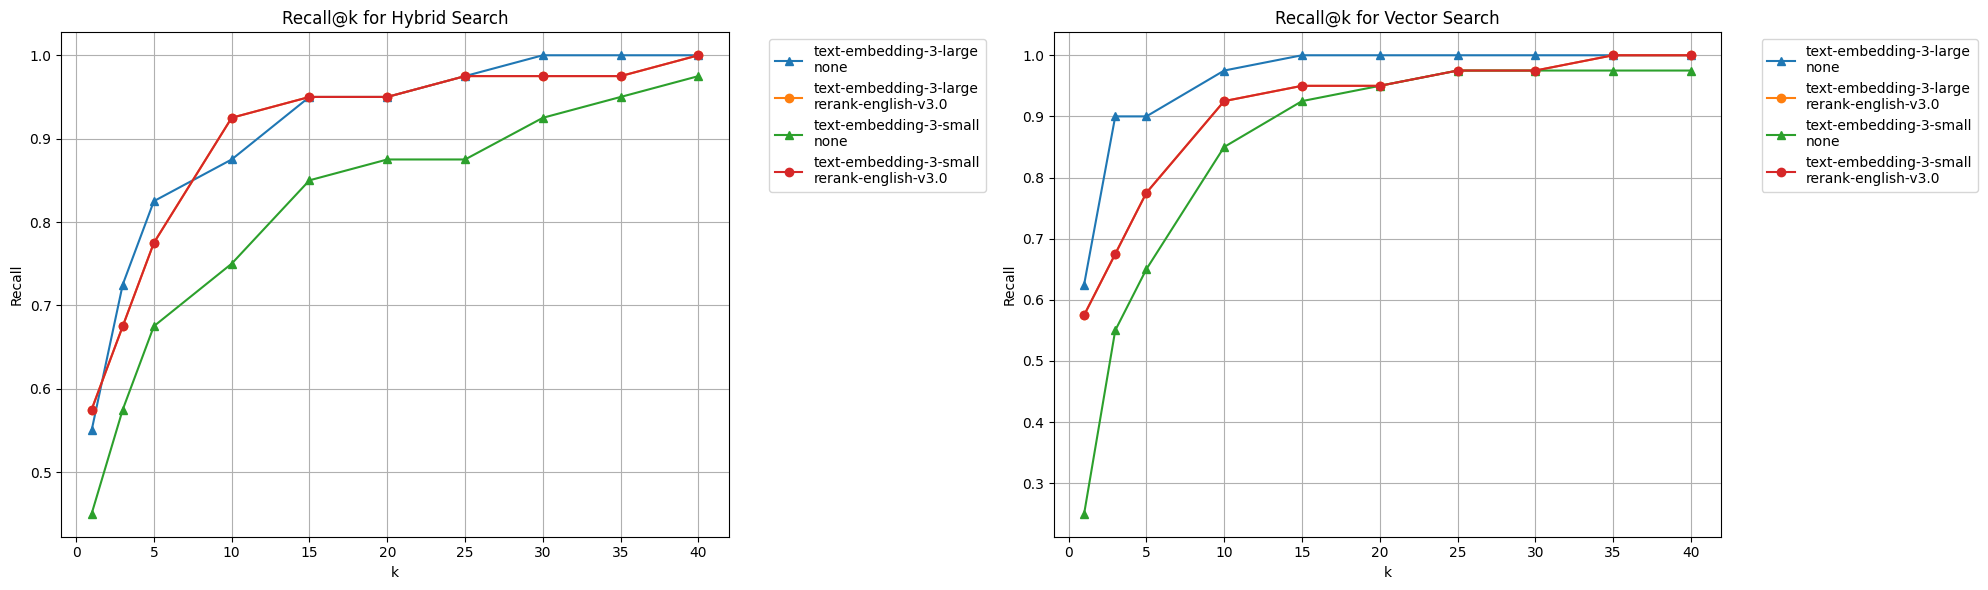

In [20]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot recall for hybrid search
hybrid_data = df[(df["metric"] == "recall") & (df["query_type"] == "hybrid")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = hybrid_data[
            (hybrid_data["reranker"] == reranker)
            & (hybrid_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax1.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax1.set_title("Recall@k for Hybrid Search")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot recall for vector search
vector_data = df[(df["metric"] == "recall") & (df["query_type"] == "vector")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = vector_data[
            (vector_data["reranker"] == reranker)
            & (vector_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax2.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax2.set_title("Recall@k for Vector Search")
ax2.set_xlabel("k")
ax2.set_ylabel("Recall")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

Based off the results above, we can see that text-embedding-3-large outperforms text-embedding-3-small for vector search while having a similar MRR and Recall@k for hybrid search.

With vector search, we can see that the `text-embedding-3-large` model achieves perfect recall at k=15 while a reranker only does so at k=15. We see a similar trend in hybrid search where the `text-embedding-3-large` model achieves perfect recall at k=30 while a reranker only does so at k=40. 

With Hybrid Search, we can see that the `text-embedding-3-large` model achieves perfect recall at k=30 while a reranker only does so at k=40. From k=15, the `text-embedding-3-large` model outperforms or matches the reranker in terms of recall.

This suggests that for this specific set of questions

1. Embeddings searchs alone should be sufficient for our retrieval needs
2. A re-ranker might not be necessary for our application's initial deployment. 

But this is something we wouldn't have been able to determine without running a set of experiments. Let's see another example below where we vary the number of items we pass into the re-ranker.

## How many items should we pass into the re-ranker?

We want to know how the performance of the re-ranker changes as we vary the number of items passed into it. This is important because the more items we pass into the re-ranker, the higher the latency.

Therefore, if we can get a good recall@k with a smaller `k`, we should choose that method. Let's modify our earlier code to support this.

We'll be using the text-embedding-3-small model for this experiment with vector search.

In [11]:
from braintrust import init_dataset, Eval
from lancedb.rerankers import CohereReranker
import uuid


# Load subset of evaluation queries
evaluation_queries = [
    item for item in init_dataset(project="Text-2-SQL", name="Bird-Bench-Questions")
]

reranker = CohereReranker(model_name="rerank-english-v3.0", column="query")
experiment_id = str(uuid.uuid4())
embedding_model = "text-embedding-3-small"
search_mode = "vector"
reranker_name = "rerank-english-v3.0"

reranker_results = []
for retrieval_limit in [40, 80, 120]:
    # Run evaluation
    benchmark_result = await Eval(
        name="Text-2-SQL",
        experiment_name=f"reranker-k-comparison-{retrieval_limit}-{experiment_id}",
        task=lambda query: retrieve(
            question=query,
            max_k=retrieval_limit,
            table=table_small,
            mode="vector",
            reranker=reranker,
        ),
        data=evaluation_queries,
        scores=[evaluate_braintrust],
        metadata={
            "retrieval_limit": retrieval_limit,
        },
    )

    # Process benchmark results
    performance_scores = benchmark_result.summary.scores
    for metric_name, score_data in performance_scores.items():
        metric_type, top_k = metric_name.split("@")
        reranker_results.append(
            {
                "metric": metric_type,
                "k": int(top_k),
                "score": score_data.score,
                "retrieval_limit": retrieval_limit,
            }
        )

Experiment reranker-k-comparison-40-88e6c54e-23bb-4f32-840d-f4e817eb3b2e is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/reranker-k-comparison-40-88e6c54e-23bb-4f32-840d-f4e817eb3b2e
Text-2-SQL [experiment_name=reranker-k-comparison-40-88e6c54e-23bb-4f32-840d-f4e817eb3b2e] (data): 290it [00:00, 44718.68it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-40-88e6c54e-23bb-4f32-840d-f4e817eb3b2e] (tasks):   0%|     …


=========================SUMMARY=========================
reranker-k-comparison-40-88e6c54e-23bb-4f32-840d-f4e817eb3b2e compared to reranker-k-comparison-120-4037f755-d4f3-4aa1-8731-33a6452286f3:
65.86% (+02.00%) 'mrr@1'     score	(2 improvements, 0 regressions)
71.95% (+01.50%) 'mrr@3'     score	(5 improvements, 0 regressions)
73.66% (+02.05%) 'mrr@5'     score	(9 improvements, 0 regressions)
74.79% (+02.00%) 'mrr@10'    score	(11 improvements, 0 regressions)
74.96% (+01.85%) 'mrr@15'    score	(11 improvements, 0 regressions)
74.96% (+01.85%) 'mrr@20'    score	(11 improvements, 0 regressions)
75.00% (+01.81%) 'mrr@25'    score	(12 improvements, 1 regressions)
75.00% (+01.81%) 'mrr@30'    score	(12 improvements, 1 regressions)
75.02% (+01.81%) 'mrr@35'    score	(13 improvements, 1 regressions)
75.02% (+01.81%) 'mrr@40'    score	(13 improvements, 1 regressions)
65.86% (+02.00%) 'recall@1'  score	(2 improvements, 0 regressions)
79.31% (-) 'recall@3'  score	(0 improvements, 0 regressions

Experiment reranker-k-comparison-80-88e6c54e-23bb-4f32-840d-f4e817eb3b2e is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/reranker-k-comparison-80-88e6c54e-23bb-4f32-840d-f4e817eb3b2e
Text-2-SQL [experiment_name=reranker-k-comparison-80-88e6c54e-23bb-4f32-840d-f4e817eb3b2e] (data): 290it [00:00, 42347.53it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-80-88e6c54e-23bb-4f32-840d-f4e817eb3b2e] (tasks):   0%|     …


=========================SUMMARY=========================
reranker-k-comparison-80-88e6c54e-23bb-4f32-840d-f4e817eb3b2e compared to reranker-k-comparison-40-88e6c54e-23bb-4f32-840d-f4e817eb3b2e:
64.14% (-01.72%) 'mrr@1'     score	(0 improvements, 5 regressions)
70.80% (-01.15%) 'mrr@3'     score	(0 improvements, 8 regressions)
72.30% (-01.36%) 'mrr@5'     score	(0 improvements, 15 regressions)
73.53% (-01.25%) 'mrr@10'    score	(1 improvements, 21 regressions)
73.67% (-01.29%) 'mrr@15'    score	(1 improvements, 25 regressions)
73.73% (-01.23%) 'mrr@20'    score	(2 improvements, 25 regressions)
73.76% (-01.24%) 'mrr@25'    score	(2 improvements, 27 regressions)
73.76% (-01.24%) 'mrr@30'    score	(2 improvements, 27 regressions)
73.79% (-01.23%) 'mrr@35'    score	(3 improvements, 29 regressions)
73.81% (-01.21%) 'mrr@40'    score	(3 improvements, 29 regressions)
64.14% (-01.72%) 'recall@1'  score	(0 improvements, 5 regressions)
78.97% (-00.34%) 'recall@3'  score	(0 improvements, 1 regre

Experiment reranker-k-comparison-120-88e6c54e-23bb-4f32-840d-f4e817eb3b2e is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/reranker-k-comparison-120-88e6c54e-23bb-4f32-840d-f4e817eb3b2e
Text-2-SQL [experiment_name=reranker-k-comparison-120-88e6c54e-23bb-4f32-840d-f4e817eb3b2e] (data): 290it [00:00, 51262.14it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-120-88e6c54e-23bb-4f32-840d-f4e817eb3b2e] (tasks):   0%|    …


=========================SUMMARY=========================
reranker-k-comparison-120-88e6c54e-23bb-4f32-840d-f4e817eb3b2e compared to reranker-k-comparison-80-88e6c54e-23bb-4f32-840d-f4e817eb3b2e:
64.14% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
70.75% (-00.06%) 'mrr@3'     score	(0 improvements, 1 regressions)
72.14% (-00.16%) 'mrr@5'     score	(0 improvements, 4 regressions)
73.38% (-00.15%) 'mrr@10'    score	(0 improvements, 6 regressions)
73.50% (-00.17%) 'mrr@15'    score	(0 improvements, 9 regressions)
73.56% (-00.17%) 'mrr@20'    score	(0 improvements, 12 regressions)
73.62% (-00.14%) 'mrr@25'    score	(0 improvements, 13 regressions)
73.62% (-00.14%) 'mrr@30'    score	(0 improvements, 13 regressions)
73.63% (-00.16%) 'mrr@35'    score	(0 improvements, 16 regressions)
73.64% (-00.17%) 'mrr@40'    score	(0 improvements, 18 regressions)
64.14% (-) 'recall@1'  score	(0 improvements, 0 regressions)
78.97% (-) 'recall@3'  score	(0 improvements, 0 regressions)
85.17% (-00.

In [18]:
reranker_df = pd.DataFrame(reranker_results)

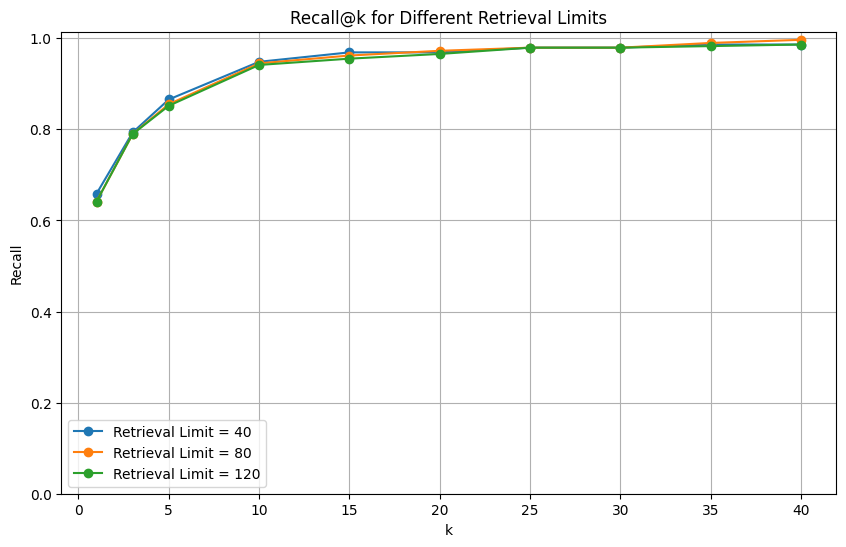

In [13]:
# Filter for recall metric and create plot
recall_df = reranker_df[reranker_df["metric"] == "recall"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = recall_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

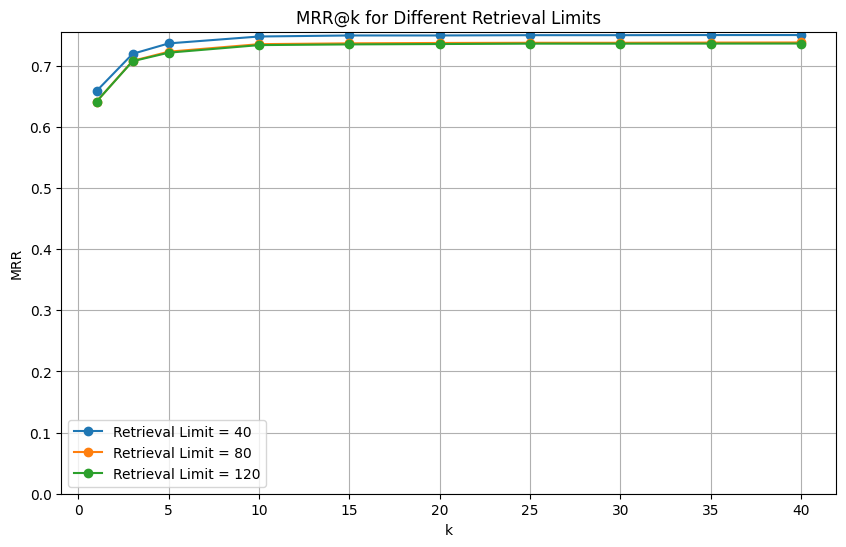

In [17]:
# Filter for recall metric and create plot
recall_df = reranker_df[reranker_df["metric"] == "mrr"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = recall_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("MRR")
plt.title("MRR@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

We can see that varying the items passed into the re-ranker results in a recall@k that is at most 0.01 higher at each step. This suggests that varying the number of items passed into the re-ranker does not impact MRR or recall significantly.

In the next notebook, we'll look at how we can use bootstrapping and t-tests to determine if the differences we observe are robust and not due to chance.